In [2]:
import seaborn as sns
import gensim
from scipy.spatial.distance import cosine
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
import pandas as pd
import nltk
import math
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import MinMaxScaler
from str_helper import *

## Helper functions

In [7]:
def get_sumvec(clean_strr, w2v_model, idf=None):
    tokens = nltk.FreqDist(word_tokenize(clean_strr))
    vecs = []
    for t,cnt in tokens.items():
        mul = 1
        if t.startswith('non-'):
            t = t.replace('non-','')
            mul = -1
        try:
            if not idf: vecs.append(w2v_model[t]*mul*cnt)
            else: vecs.append(w2v_model[t]*mul*cnt*idf[t])
            
        except KeyError:
            continue
    return np.array(vecs).sum(0)




#Vectorize constructs definition
def gen_rdoc_dict(w2v_model):
    rdoc={}
    rdoc['fear'] = {'dfn':"Activation of the brain’s defensive motivational system to promote behaviors that protect the organism from perceived danger. Normal fear involves a pattern of adaptive responses to conditioned or unconditioned threat stimuli (exteroceptive or interoceptive). Fear can involve internal representations and cognitive processing and can be modulated by a variety of factors."}
    rdoc['loss'] = {'dfn':"A state of deprivation of a motivationally non-significant con-specific, object, or situation. Loss may be social or non-social and may include permanent or sustained loss of shelter, behavioral control, status, loved ones, or relationships. The response to loss may be episodic (e.g., grief) or sustained."}
    rdoc['sleep_wf'] = {'dfn': "Sleep and wakefulness endogenous, recurring, behavioral states that reflect coordinated changes in the dynamic functional organization of the brain and that optimize physiology, behavior, and health. Homeostatic and circadian processes regulate the propensity for wakefulness and sleep."}
    rdoc['circadian'] = {'dfn': " Circadian rhythms are endogenous self-sustaining oscillations that organize the timing of biological systems to optimize physiology and behavior, and health. They are synchronized by recurring environmental cues; anticipate the external environment; allow effective response to challenges and opportunities in the physical and social environment; modulate homeostasis within the brain and other (central/peripheral) systems, tissues and organs; are evident across levels of organization including molecules, cells, circuits, systems, organisms, and social systems."}
    rdoc['arousal'] = {'dfn':" Arousal is a continuum of sensitivity of the organism to stimuli, both external and internal. Arousal facilitates interaction with the environment in a context-specific manner (e.g., under conditions of threat, some stimuli must be ignored while sensitivity to and responses to others is enhanced, as exemplified in the startle reflex). It can be evoked by either external/environmental stimuli or internal stimuli (e.g., emotions and cognition). I can be modulated by the physical characteristics and motivational significance of stimuli. It varies along a continuum that can be quantified in any behavioral state, including wakefulness and low-arousal states including sleep, anesthesia, and coma. Arousal is distinct from motivation and valence but can covary with intensity of motivation and valence. It may be associated with increased or decreased locomotor activity, and can be regulated by homeostatic drives (e.g., hunger, sleep, thirst, sex)."}
    rdoc['frusnrew'] = {'dfn': "Frustrate Non-reward: Reactions elicited in response to withdrawal/prevention of reward, i.e., by the inability to obtain positive rewards following repeated or sustained efforts."}
    rdoc['anxiety'] = {'dfn': "Activation of a brain system in which harm may potentially occur but is distant, ambiguous, or low/uncertain in probability, characterized by a pattern of responses such as enhanced risk assessment (vigilance). These responses to low imminence threats are qualitatively different than the high imminence threat behaviors that characterize fear."}
    rdoc['susthreat'] = {'dfn':"An aversive emotional state caused by prolonged (i.e., weeks to months) exposure to internal and/or external condition(s), state(s), or stimuli that are adaptive to escape or avoid. The exposure may be actual or anticipated; the changes in affect, cognition, physiology, and behavior caused by sustained threat persist in the absence of the threat and can be differentiated from those changes evoked by acute threat."}
    # get cleaned defn
    for key in rdoc:
        rdoc[key]['clean'] = clean_sent(rdoc[key]['dfn'])
    dfn_list = [rdoc[key]['clean'] for key in rdoc]
    construct_idf = idf(dfn_list)
    # get_sumvec for definitons
    for key in rdoc:
        rdoc[key]['vec'] = get_sumvec(rdoc[key]['clean'], w2v_model, construct_idf)
    return rdoc


#Vectorize test data + get Sim
def compute_sim(w2v_model, out_fname='test_results.csv', test_fname='data/training_data.csv'):
    rdoc = gen_rdoc_dict(w2v_model)
    test_data = pd.read_csv(test_fname)
    test_data['content'] = test_data['title']+test_data['abstract'] 
    test_idf = idf(test_data['content'].values)
    test_data['vec'] = test_data['content'].apply(get_sumvec, args=(w2v_model, test_idf, ))
    for key in rdoc:
        keyvec = rdoc[key]['vec']
        test_data[key+'_sim'] = test_data['vec'].apply(sim, args=(keyvec,))
    test_data.to_csv(out_fname)
    return test_data

# Get avg precision for each construct from results df
def avg_precision(results_df):
    precision = pd.Series(index=results_df.rdoc.unique())
    for rdoc in precision.index:
        df1 = results_df.copy()
        df1['rdoc'] = np.where(df1['rdoc']==rdoc, 1, 0) #tag relevant/irrelevant groudn truth
        precision[rdoc] = average_precision_score(df1['rdoc'], df1[rdoc+'_sim']) # compute based on relevance score
    return precision

def get_model(f):
    return gensim.models.Word2Vec.load(f)

def get_heatmaps(results_df, rdoc, prec=''):
    df=results_df[results_df.rdoc==rdoc].copy()
    relevance_c = [c for c in df.columns if '_sim' in c]
    scores = MinMaxScaler().fit_transform(df[relevance_c].T).T
    xlabels = [c.replace('_sim','') for c in relevance_c]
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 5)
    plt.title(rdoc+' '+str(prec))
    sns.heatmap(scores, center=0.5, xticklabels=xlabels)
    

def get_ap(adf):
    qap={}
    df = adf.copy()
    for const in df.rdoc.unique():
        df.sort_values(const+'_sim', ascending=False, inplace=True)
        df['docid'] = range(1,len(df)+1)
        df['groundtruth'] = np.where(df.rdoc==const, 1, 0)
        tp = 0
        ap=0
        for _, row in df.iterrows():
            tp+=row['groundtruth']
            ap += tp*row['groundtruth']/row['docid']
        qap[const] = ap/df['groundtruth'].sum()
    return qap

## Evaluate Model

In [8]:
model = get_model('models/w2v_sg_w10.model.wv.vectors.npy')
results = compute_sim(model, 'results/test_results_sg_w10_tfidf_pos.csv')
precision = avg_precision(results)

for rdoc in precision.index:
    get_heatmaps(results, rdoc, precision[rdoc])

UnpicklingError: STACK_GLOBAL requires str

## Get mAP

In [40]:
import os
results_df_list = []
for results in os.listdir('results/'):
    results_df_list.append((results, pd.read_csv('results/'+results)))

ap_df = pd.concat(list(map(avg_precision, [tup[1] for tup in results_df_list])), axis=1)
ap_df.columns = [tup[0].replace('.csv','').replace('test_results_','') for tup in results_df_list]
ap_df.loc[len(ap_df)] = ap_df.mean()
ap_df.index = list(ap_df.index)[:-1]+['MAP']
ap_df[['unweighted','tfidf','tfidf_posfilt', 'sg_w10_tfidf_pos']]

,unweighted,tfidf,tfidf_posfilt,sg_w10_tfidf_pos
fear,0.331225,0.394218,0.408762,0.383806
loss,0.267024,0.742487,0.780494,0.840315
arousal,0.313597,0.579911,0.537592,0.506523
circadian,0.439948,0.278955,0.284175,0.406311
frusnrew,0.061585,0.071679,0.077010,0.079673
anxiety,0.356331,0.316097,0.341975,0.434728
sleep_wf,0.360360,0.520229,0.563937,0.415623
susthreat,0.232491,0.213766,0.226111,0.234838
MAP,0.295320,0.389668,0.402507,0.412727


## Get heatmaps

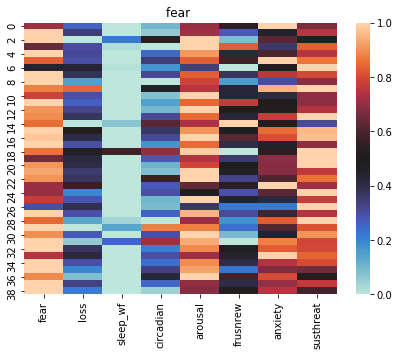

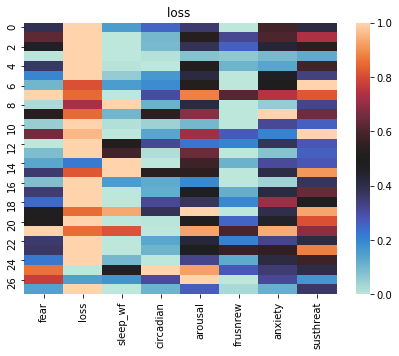

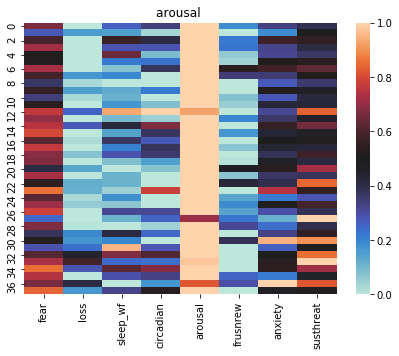

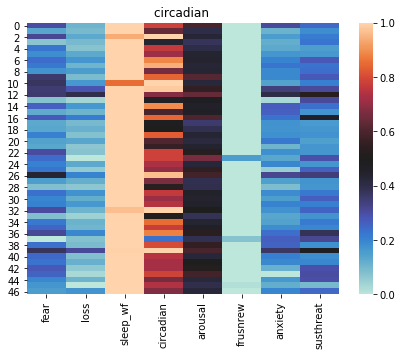

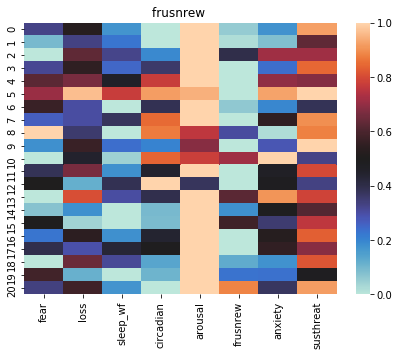

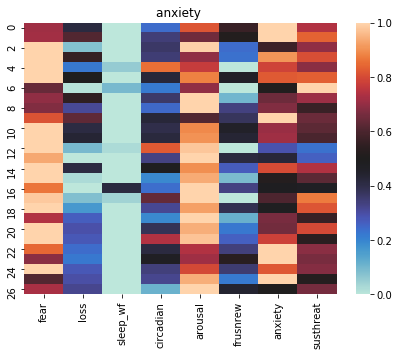

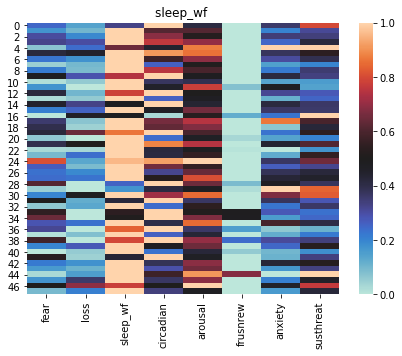

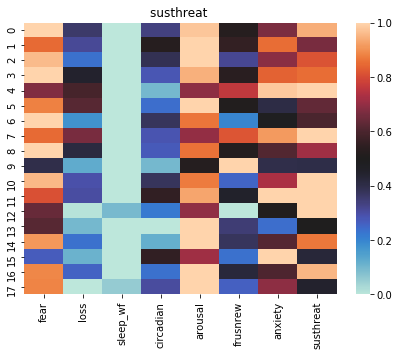

In [6]:
import os
results_df_list = []
for results in os.listdir('results/'):
    results_df_list.append((results, pd.read_csv('results/'+results)))

df = results_df_list[1][1]
for rdoc in df.rdoc.unique():
    get_heatmaps(df, rdoc)